<a href="https://colab.research.google.com/github/WahomeKezia/PlantDisease_Identifier_API/blob/main/Plants_Diseases_ResNet9_CNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
#Import TensorFlow and other necessary libraries

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix

# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from keras.optimizers import Adam
from keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.experimental import preprocessing
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


print(tf.__version__)

2.15.0



The data-set has 39 different classes of plant leaf and background images are available.  The data-set containing 61,486 images. the dataset has used six different augmentation techniques for increasing the data-set size. The techniques are image flipping, Gamma correction, noise injection, PCA color augmentation, rotation, and Scaling.

```
The classes are,
1.Apple_scab
2.Apple_black_rot
3.Apple_cedar_apple_rust
4.Apple_healthy
5.Background_without_leaves
6.Blueberry_healthy
7.Cherry_powdery_mildew
8.Cherry_healthy
9.Corn_gray_leaf_spot
10.Corn_common_rust
11.Corn_northern_leaf_blight
12.Corn_healthy
13.Grape_black_rot
14.Grape_black_measles
15.Grape_leaf_blight
16.Grape_healthy
17.Orange_haunglongbing
18.Peach_bacterial_spot
19.Peach_healthy
20.Pepper_bacterial_spot
21.Pepper_healthy
22.Potato_early_blight
23.Potato_healthy
24.Potato_late_blight
25.Raspberry_healthy
26.Soybean_healthy
27.Squash_powdery_mildew
28.Strawberry_healthy
29.Strawberry_leaf_scorch
30.Tomato_bacterial_spot
31.Tomato_early_blight
32.Tomato_healthy
33.Tomato_late_blight
34.Tomato_leaf_mold
35.Tomato_septoria_leaf_spot
36.Tomato_spider_mites_two-spotted_spider_mite
37.Tomato_target_spot
38.Tomato_mosaic_virus
39.Tomato_yellow_leaf_curl_virus


```



In [ ]:
#mounting the dataset
from google.colab import drive

drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

Accessing a dataset from Kaggle , Copied the API

In [ ]:
!kaggle datasets download -d dev523/leaf-disease-detection-dataset

100% 1.33G/1.34G [00:15<00:00, 49.6MB/s]
100% 1.34G/1.34G [00:15<00:00, 92.8MB/s]


In [ ]:
import zipfile
import os

# Replace 'dev523/leaf-disease-detection-dataset.zip' with the actual name of the downloaded zip file.
with zipfile.ZipFile('leaf-disease-detection-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')


In [ ]:

import shutil  # Add this line for the 'shutil' module

# Define your dataset paths
dataset = {
    "train_data": "/content/dataset/train",
    "valid_data": "/content/dataset/test",
    "test_data": "/content/images_for_test"
}

In [ ]:
import os
import shutil
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# No need to create a new folder for the validation dataset, as 'test' will act as validation

# Initialize lists for all datasets
all_data_train = []
all_data_valid = []
all_data_test = []

# Populate lists for train, valid, and test
for data_type, path in dataset.items():
    data = {"imgpath": [], "labels": []}
    category = os.listdir(path)

    for folder in category:
        folderpath = os.path.join(path, folder)
        if os.path.isdir(folderpath):
            filelist = os.listdir(folderpath)
            for file in filelist:
                fpath = os.path.join(folderpath, file)
                data["imgpath"].append(fpath)
                data["labels"].append(folder)

            if data_type == "train_data":
                all_data_train.append(data.copy())
            elif data_type == "valid_data":
                all_data_valid.append(data.copy())
            else:
                all_data_test.append(data.copy())

# Check if the test dataset is not empty before creating the DataFrame
test_df = pd.DataFrame(all_data_test[0], index=range(len(all_data_test[0]['imgpath']))) if all_data_test else None

# Create DataFrames for train, valid, and test
train_df = pd.DataFrame(all_data_train[0], index=range(len(all_data_train[0]['imgpath'])))
valid_df = pd.DataFrame(all_data_valid[0], index=range(len(all_data_valid[0]['imgpath'])))

# Convert labels to numbers
lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['labels'])
valid_df['encoded_labels'] = lb.fit_transform(valid_df['labels'])
if test_df is not None:
    test_df['encoded_labels'] = lb.fit_transform(test_df['labels'])


#Exploratory Data Analysis

In [ ]:
# Get the list of diseases from the 'train' directory
diseases = os.listdir(dataset["train_data"])

# Print the list of diseases
print("List of diseases in the dataset:", diseases)

List of diseases in the dataset: ['Grape___healthy', 'Cherry_(including_sour)___healthy', 'Potato___healthy', 'Tomato___healthy', 'Raspberry___healthy', 'Corn_(maize)___Common_rust_', 'Orange___Haunglongbing_(Citrus_greening)', 'Corn_(maize)___healthy', 'Tomato___Late_blight', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___healthy', 'Peach___Bacterial_spot', 'Tomato___Leaf_Mold', 'Soybean___healthy', 'Pepper,_bell___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Apple___Cedar_apple_rust', 'Grape___Esca_(Black_Measles)', 'Blueberry___healthy', 'Strawberry___Leaf_scorch', 'Squash___Powdery_mildew', 'Tomato___Target_Spot', 'Tomato___Early_blight', 'Tomato___Tomato_mosaic_virus', 'Apple___Apple_scab', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Apple___healthy', 'Strawberry___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Ye

In [ ]:
print("Total disease classes are: {}".format(len(diseases)))


Total disease classes are: 38


In [ ]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

The above cell extract the number of unique plants and number of unique diseases

In [ ]:
# unique plants in the dataset
print(f"Unique Plants are: \n{plants}")

Unique Plants are: 
['Grape', 'Cherry_(including_sour)', 'Potato', 'Tomato', 'Raspberry', 'Corn_(maize)', 'Orange', 'Peach', 'Soybean', 'Pepper,_bell', 'Apple', 'Blueberry', 'Strawberry', 'Squash']


In [ ]:
# number of unique plants
print("Number of plants: {}".format(len(plants)))

Number of plants: 14


In [ ]:
# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

Number of diseases: 26


The dataset has images of leaves from 14 plants and while excluding healthy leavesit has 26 types of images that show a particular disease in a particular plant.

In [ ]:
# Number of images for each disease
nums = {}

# Assuming 'labels' column in train_df contains disease names
for disease in train_df['labels'].unique():
    disease_path = os.path.join("/content/dataset/train", disease)  # Adjust the path to the actual location of your training images
    nums[disease] = len(os.listdir(disease_path))

# Convert the nums dictionary to a pandas DataFrame
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])

# Print the DataFrame
print("Number of images per class:")
print(img_per_class)



Number of images per class:
                                                    no. of images
Grape___healthy                                              1692
Cherry_(including_sour)___healthy                            1826
Potato___healthy                                             1824
Tomato___healthy                                             1926
Raspberry___healthy                                          1781
Corn_(maize)___Common_rust_                                  1907
Orange___Haunglongbing_(Citrus_greening)                     2010
Corn_(maize)___healthy                                       1859
Tomato___Late_blight                                         1851
Cherry_(including_sour)___Powdery_mildew                     1683
Peach___healthy                                              1728
Peach___Bacterial_spot                                       1838
Tomato___Leaf_Mold                                           1882
Soybean___healthy                               

In [ ]:
valid_df, test_df = train_test_split(valid_df, train_size=0.90, shuffle=True, random_state=124)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

Traing Data images count per class: The dataset is fairly distributed


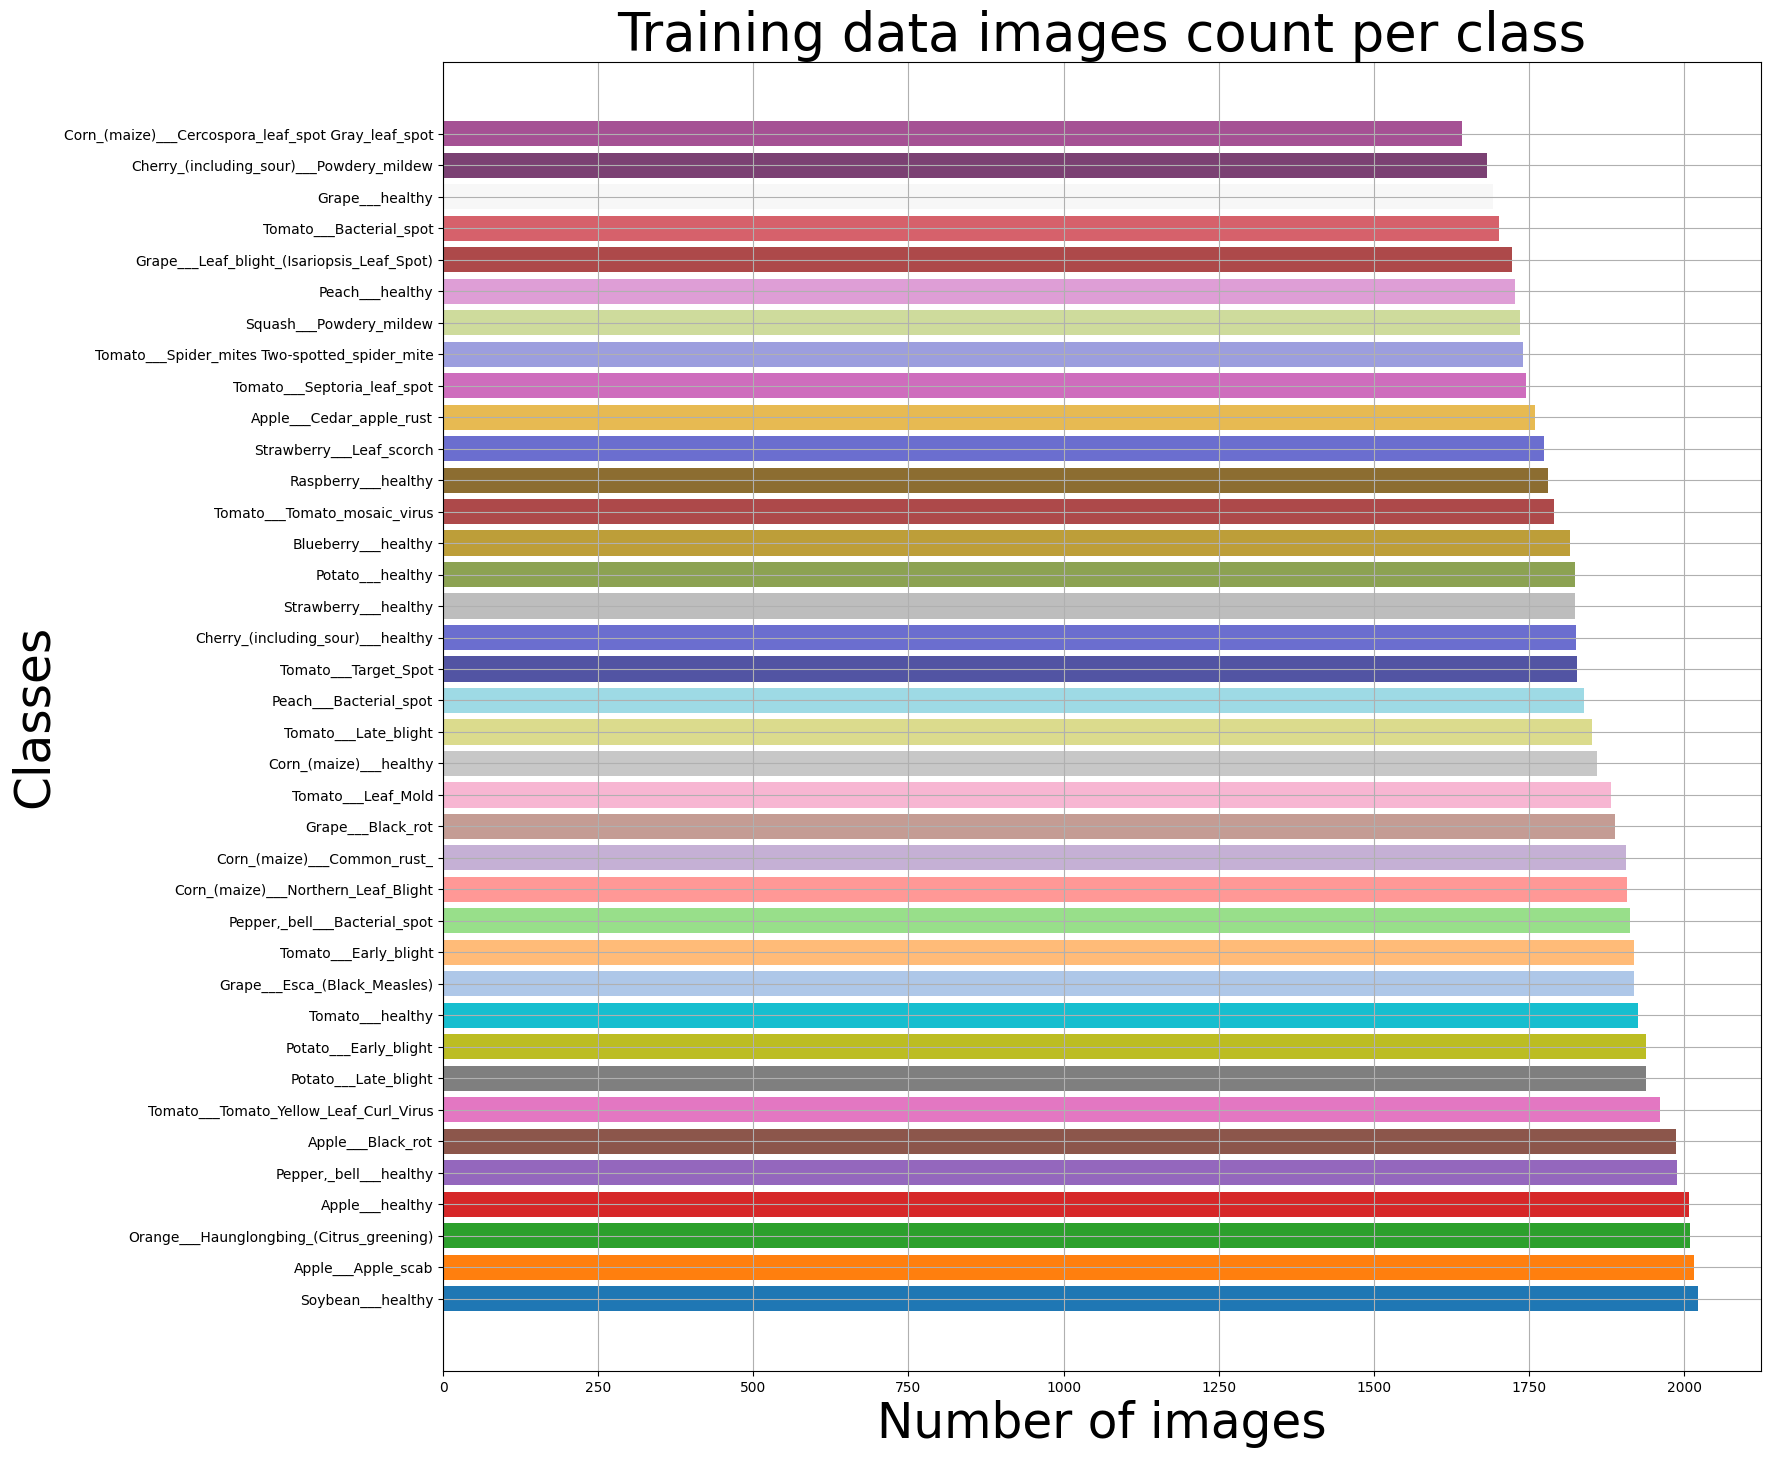

In [ ]:
train  = train_df["labels"].value_counts()
label = train.tolist()
index = train.index.tolist()

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#f7f7f7", "#7b4173", "#a55194", "#ce6dbd"
]



plt.figure(figsize=(17,17))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()


Text(0.5, 1.0, 'Images per each class of plant disease')

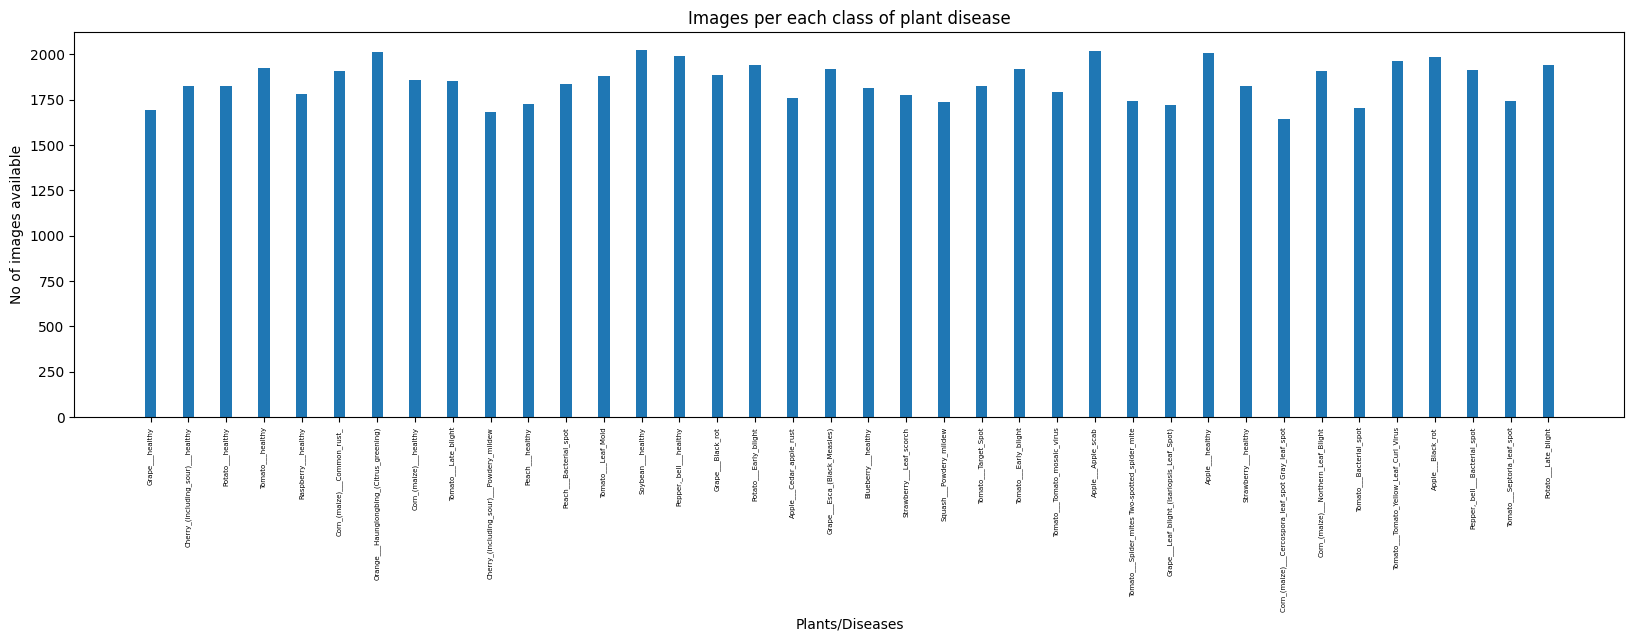

In [ ]:
# plotting number of images available for each disease
index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

In [ ]:
train_df.sample(n=15, random_state=1)

imgpath  \
59490  /content/dataset/train/Tomato___Bacterial_spot...   
58840  /content/dataset/train/Corn_(maize)___Northern...   
11750  /content/dataset/train/Orange___Haunglongbing_...   
19617  /content/dataset/train/Peach___healthy/9233054...   
48429  /content/dataset/train/Tomato___Spider_mites T...   
46935  /content/dataset/train/Apple___Apple_scab/7231...   
42758  /content/dataset/train/Tomato___Early_blight/e...   
33007  /content/dataset/train/Apple___Cedar_apple_rus...   
42522  /content/dataset/train/Tomato___Early_blight/4...   
43380  /content/dataset/train/Tomato___Early_blight/6...   
59502  /content/dataset/train/Tomato___Bacterial_spot...   
61584  /content/dataset/train/Tomato___Tomato_Yellow_...   
49104  /content/dataset/train/Tomato___Spider_mites T...   
58274  /content/dataset/train/Corn_(maize)___Northern...   
53481  /content/dataset/train/Apple___healthy/4839a9b...   

                                              labels  encoded_labels  
59490                        Tomato___Bacterial_spot              28  
58840            Corn_(maize)___Northern_Leaf_Blight               9  
11750       Orange___Haunglongbing_(Citrus_greening)              15  
19617                                Peach___healthy              17  
48429  Tomato___Spider_mites Two-spotted_spider_mite              33  
46935                             Apple___Apple_scab               0  
42758                          Tomato___Early_blight              29  
33007                       Apple___Cedar_apple_rust               2  
42522                          Tomato___Early_blight              29  
43380                          Tomato___Early_blight              29  
59502                        Tomato___Bacterial_spot              28  
61584         Tomato___Tomato_Yellow_Leaf_Curl_Virus              35  
49104  Tomato___Spider_mites Two-spotted_spider_mite              33  
58274            Corn_(maize)___Northern_Leaf_Blight               9  
53481                                Apple___healthy               3

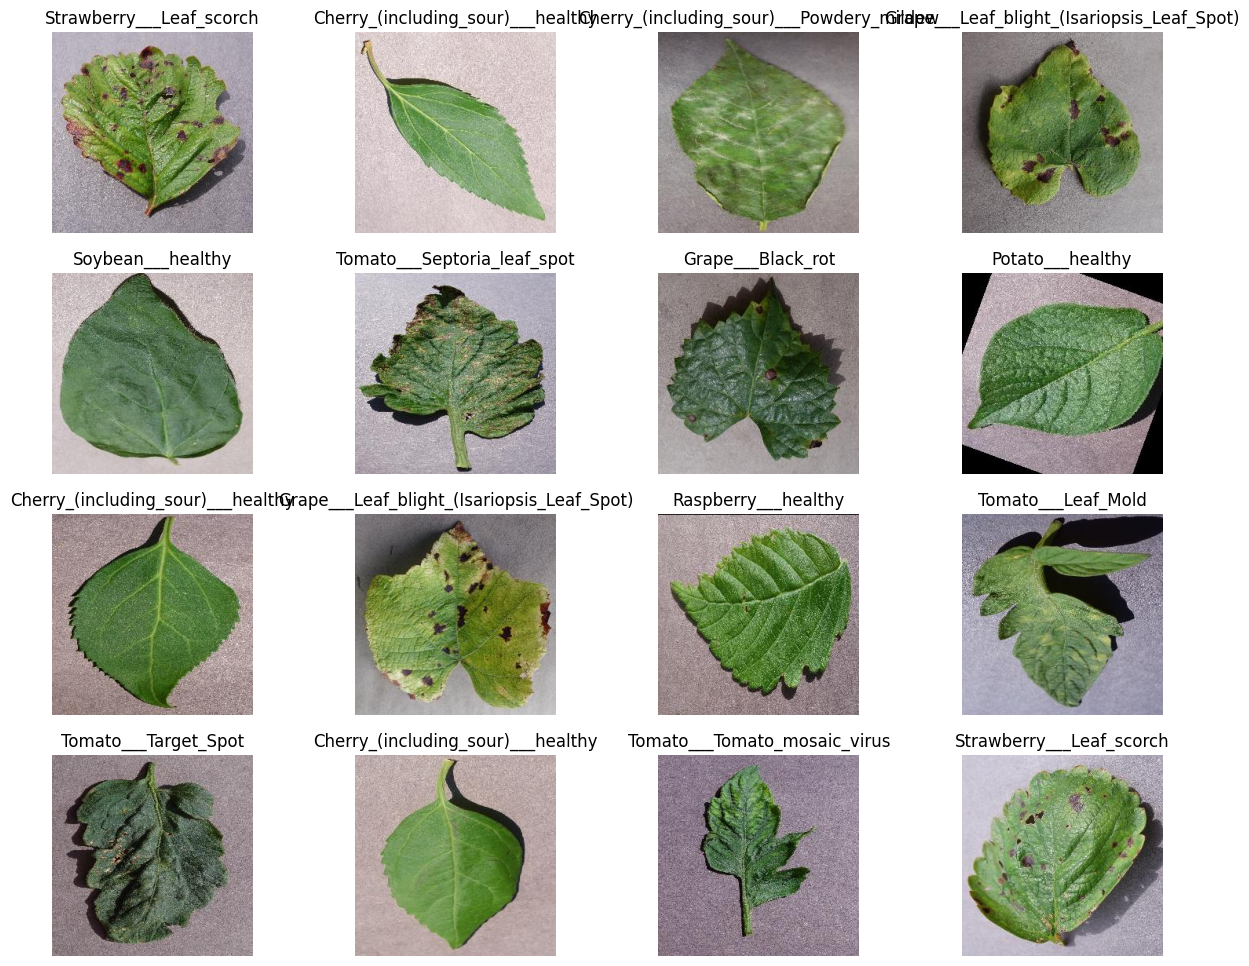

In [ ]:
plt.figure(figsize=(15,12))
for i, row in valid_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [ ]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 70295 images for training


#Data Preparation for training

Show sample from data

In [ ]:
!pip install torchsummary

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Define the paths to your training and validation directories
train_dir = "/content/dataset/train"
valid_dir = "/content/dataset/test"

# Define transformations for the images
transform = transforms.Compose([
    transforms.ToTensor(),

])

# Create ImageFolder datasets
train_dataset = ImageFolder(train_dir, transform=transform)
valid_dataset = ImageFolder(valid_dir, transform=transform)

# Access an example image and label
img, label = train_dataset[0]
print(img.shape, label)


torch.Size([3, 256, 256]) 0


Image shapes

In [ ]:
# total number of classes in train set
len(train_dataset.classes)

38

Label :Apple___Apple_scab(0)


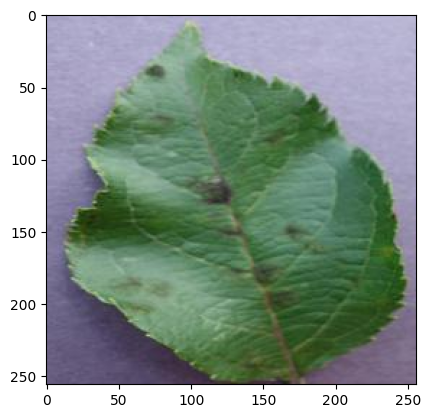

In [ ]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train_dataset.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

# Display an image from the training dataset
show_image(*train_dataset[0])

Label :Tomato___healthy(37)


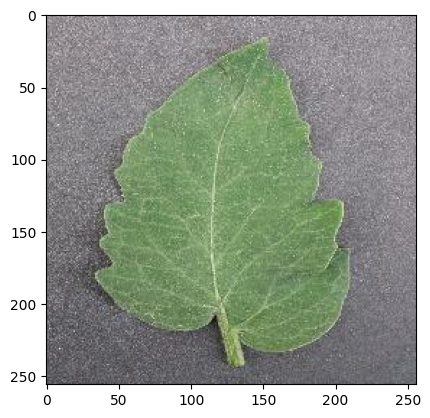

In [ ]:
show_image(*train_dataset[70000])

In [ ]:
# setting the batch size
batch_size = 32

#Creating Dataloaders

In [ ]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 32

# Create DataLoader instances for training and validation datasets
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2, pin_memory=True)


In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

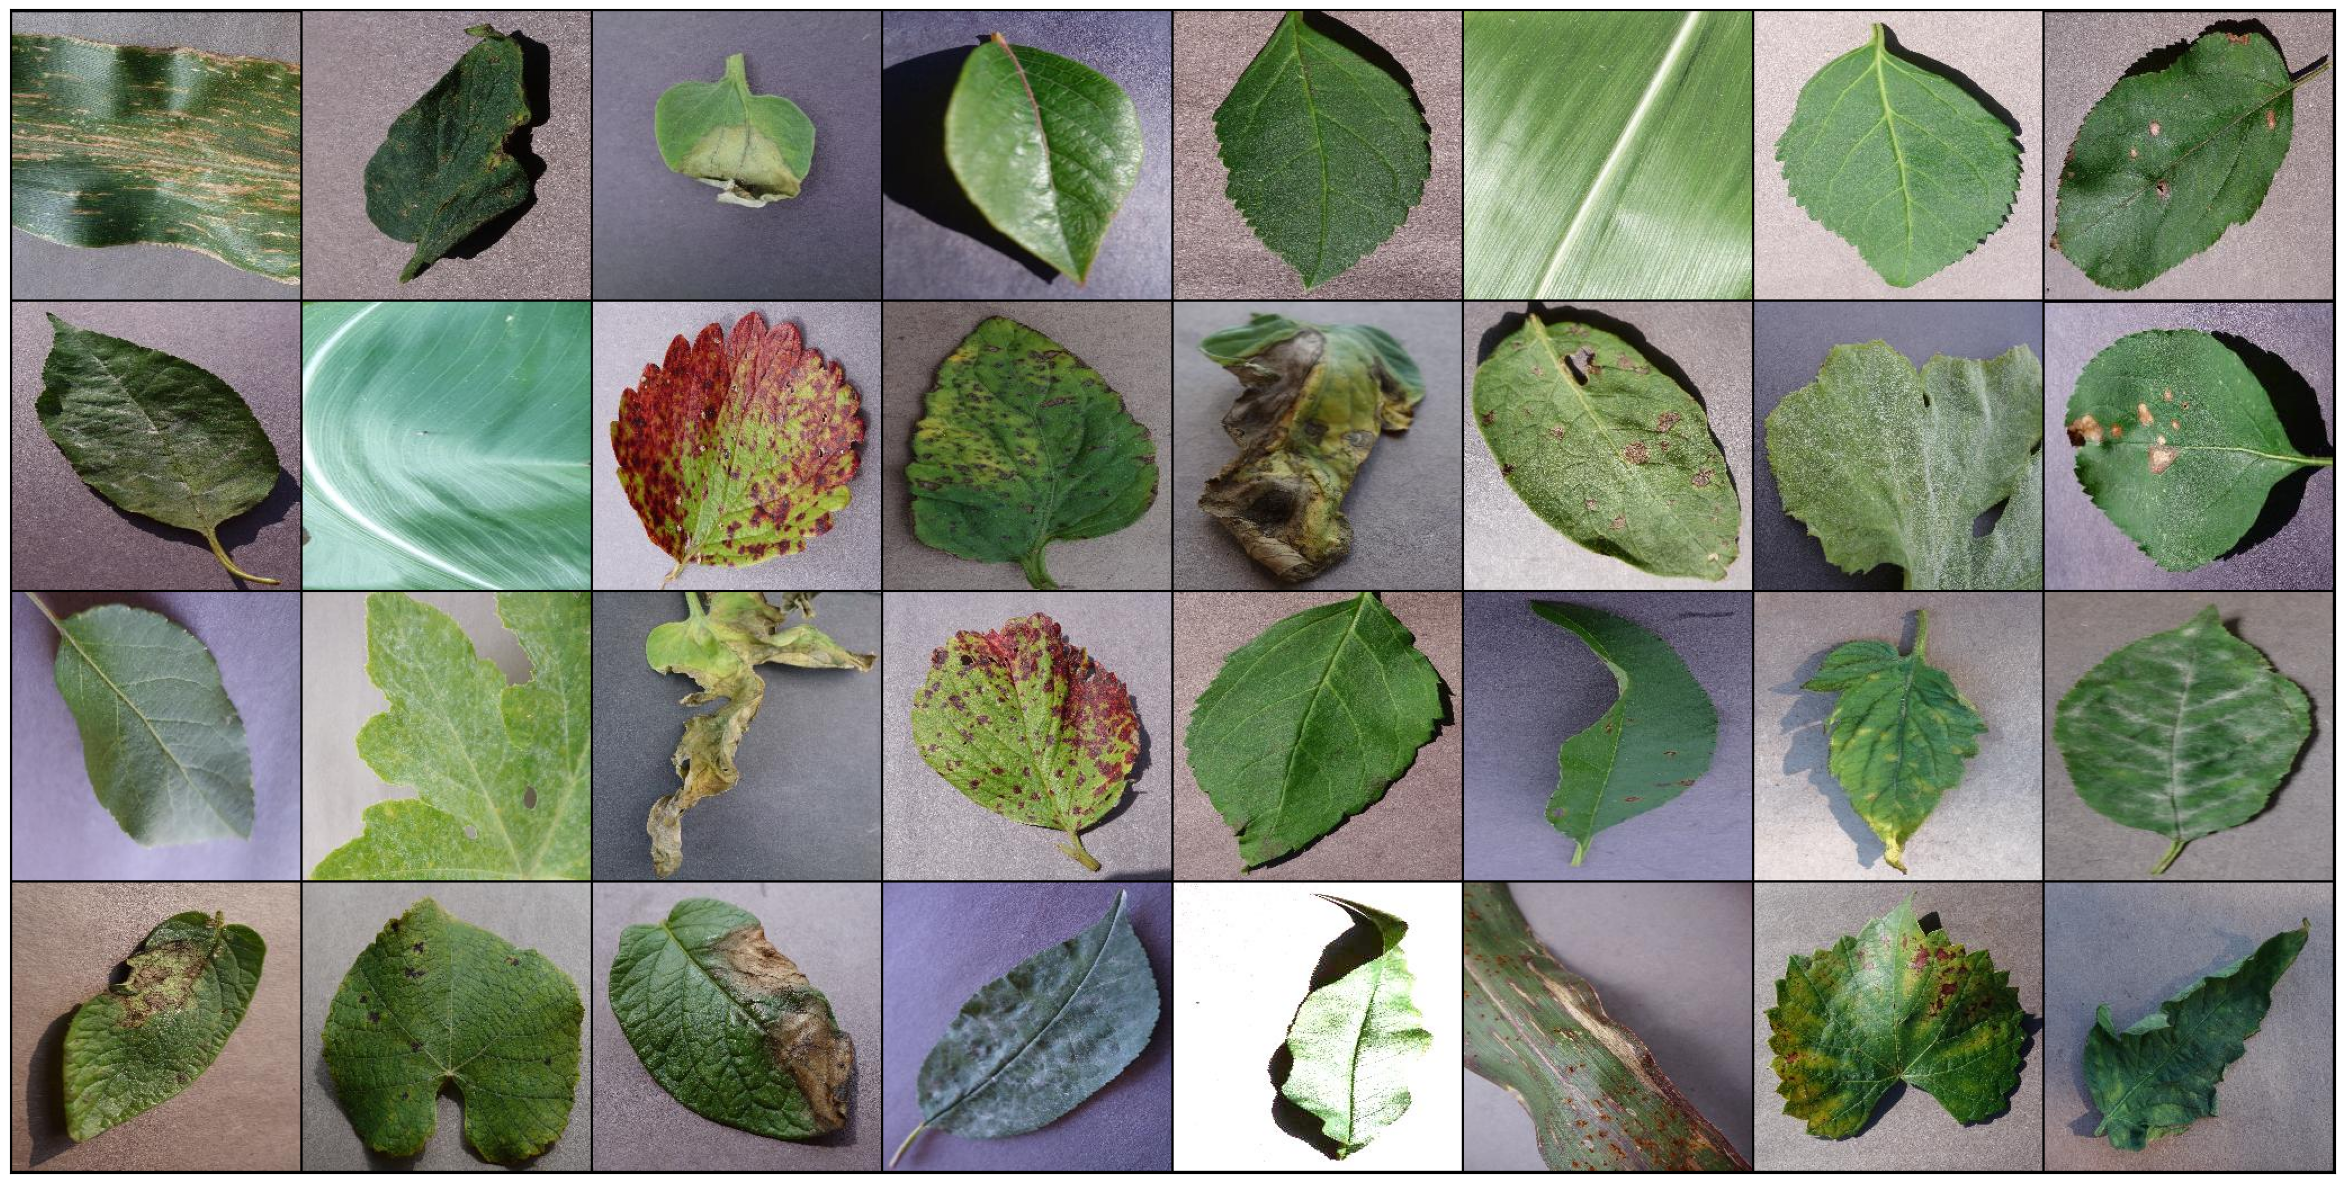

In [ ]:
# Images for first batch of training
show_batch(train_dl)

#MODELING

Some helper functions

In [ ]:
import torch

 # for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Checking the device we are working with

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


#Building the model architecture

 Using ResNet, which have been one of the major breakthrough in computer vision since they were introduced in 2015.

Residual Block code implementation

In [ ]:
import torch.nn as nn

class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

Then we define our ImageClassificationBase class whose functions are:

training_step - To figure out how “wrong” the model is going after training or validation step.We are using this function other than just an accuracy metric that is likely not going to be differentiable (this would mean that the gradient can’t be determined, which is necessary for the model to improve during training)
A quick look at the PyTorch docs that yields the cost function: cross_entropy.

validation_step - Because an accuracy metric can’t be used while training the model, doesn’t mean it shouldn’t be implemented! Accuracy in this case would be measured by a threshold, and counted if the difference between the model’s prediction and the actual label is lower than that threshold.
validation_epoch_end - We want to track the validation losses/accuracies and train losses after each epoch, and every time we do so we have to make sure the gradient is not being tracked.
epoch_end - We also want to print validation losses/accuracies, train losses and learning rate too because we are using learning rate scheduler (which will change the learning rate after every batch of training) after each epoch.
We also define an accuracy function which calculates the overall accuracy of the model on an entire batch of outputs, so that we can use it as a metric in fit_one_cycle

In [ ]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))



# Defining the final architecture of our model

In [ ]:
# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)
# resnet architecture
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()

        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out



In [ ]:
in_channels = 3  # Adjust based on the number of input channels in your dataset
num_diseases = len(train_dataset.classes)  # Number of output classes

model = ResNet9(in_channels, num_diseases)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

#Training the model

Before we train the model, Let’s define a utility functionan evaluate function, which will perform the validation phase, and a fit_one_cycle function which will perform the entire training process. In fit_one_cycle, we have use some techniques:


```
Learning Rate Scheduling , Weight Decay , Gradient Clipping
```





In [ ]:
import torch.nn.functional as F

#for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()

            # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history


Let's check our validation loss and accuracy

In [ ]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 55.5 s, sys: 5.5 s, total: 1min
Wall time: 1min 9s


[{'val_loss': tensor(3.6388, device='cuda:0'), 'val_accuracy': tensor(0.0283)}]

Since there are randomly initialized weights, that is why accuracy come to near 0.028 (that is 2.8% chance of getting the right answer or you can say model randomly chooses a class). Now, declare some hyper parameters for the training of the model. We can change it if result is not satisfactory.

In [ ]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

Let's start training our model ....

In [ ]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=1e-4,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00812, train_loss: 0.7399, val_loss: 0.9340, val_acc: 0.7141
Epoch [1], last_lr: 0.00000, train_loss: 0.1224, val_loss: 0.0256, val_acc: 0.9922
CPU times: user 14min 13s, sys: 16min 55s, total: 31min 8s
Wall time: 32min 17s


We got an accuracy of 99.2 %


📈 Plotting 📈

Helper functions for plotting

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]

    # Convert CUDA tensors to CPU tensors before converting to NumPy arrays
    accuracies = [x.cpu().numpy() if isinstance(x, torch.Tensor) and x.is_cuda else x for x in accuracies]

    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]

    # Convert CUDA tensors to CPU tensors before converting to NumPy arrays
    train_losses = [x.cpu().numpy() if isinstance(x, torch.Tensor) and x.is_cuda else x for x in train_losses]
    val_losses = [x.cpu().numpy() if isinstance(x, torch.Tensor) and x.is_cuda else x for x in val_losses]

    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])

    # Convert CUDA tensors to CPU tensors before converting to NumPy arrays
    lrs = [x.cpu().numpy() if isinstance(x, torch.Tensor) and x.is_cuda else x for x in lrs]

    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')
    plt.show()


Validation Accuracy


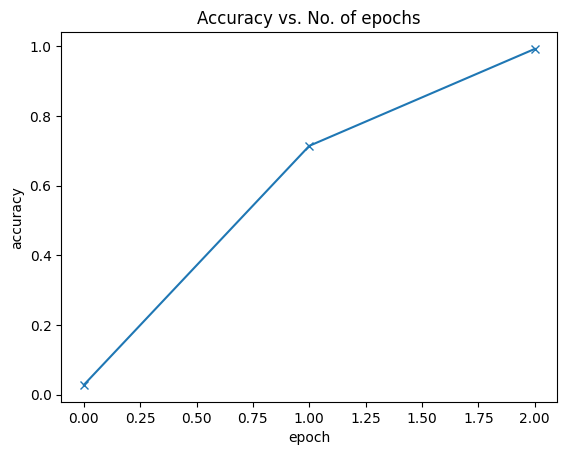

In [ ]:
plot_accuracies(history)

Validation loss


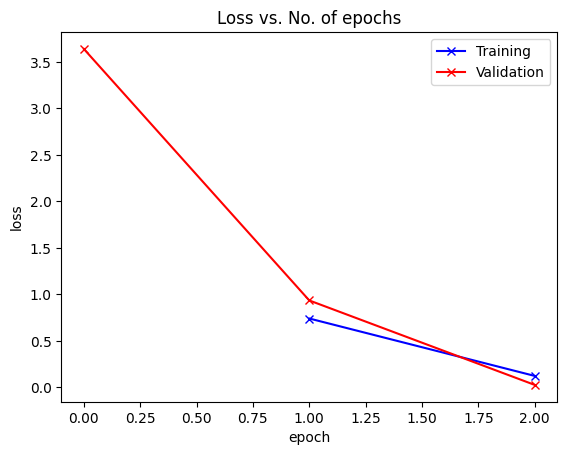

In [ ]:
plot_losses(history)


Learning Rate overtime

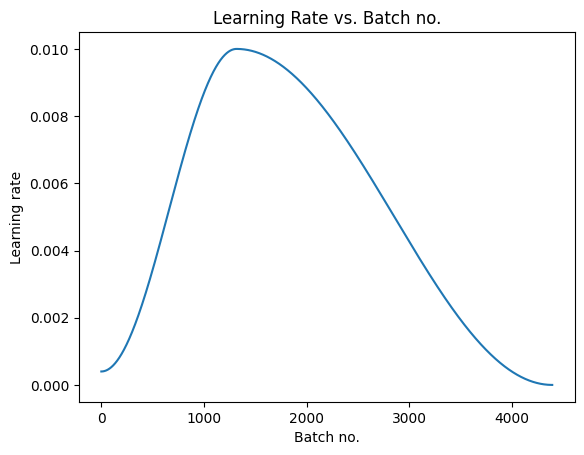

In [ ]:
plot_lrs(history
         )

#Testing model on test data

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

test_dir = "/content/images_for_test"

# Define transformations for the images
transform = transforms.Compose([
    transforms.ToTensor(),
])



#Saving the Model

In [ ]:
import os

drive_path = '/content/drive/My Drive/kaggle'

model_filename = "plant-disease-model.pth"
torch.save(model.state_dict(), f"{drive_path}/{model_filename}")


saving model for mobile application